## ERA Session7 Assignment: Model5
### Target
 - Reduce the number of parameters to under 8k
 - Alter the kernel numbers from 10>16 to 10>10 and then 10>16, basically maintain kernel number and then increase, to reduce no of params
 - Add Rotational image transformations to increase the accuracies

### Results
 - No. of Params: 7550
 - Best Test Accuracy: 99.26%
 - Best Train Accuracy: 98.73%

### Analysis
 - Number of parametrs reduced from 8480 to 7550
 - Altering the layers approach helped to reduce the number of parameters
 - Even after image augmentaton maximum accuracy achieved is 99.26% :( :( :(


In [37]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [38]:
from models import Model5 as Model

In [39]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [40]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [41]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [42]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Model().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,440
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             900
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1, 10,

In [43]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_loss = []
epoch_train_acc = []
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  epoch_train_loss.append(sum(train_losses[-train_loader.batch_size:])/(train_loader.batch_size))
  epoch_train_acc.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [44]:
model =  Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.2097925990819931 Batch_id=468 Accuracy=84.04: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s]



Test set: Average loss: 0.0977, Accuracy: 9712/10000 (97.12%)

EPOCH: 2


Loss=0.11722484976053238 Batch_id=468 Accuracy=96.71: 100%|██████████| 469/469 [00:28<00:00, 16.74it/s]



Test set: Average loss: 0.0712, Accuracy: 9772/10000 (97.72%)

EPOCH: 3


Loss=0.05852845683693886 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:28<00:00, 16.27it/s]



Test set: Average loss: 0.0478, Accuracy: 9849/10000 (98.49%)

EPOCH: 4


Loss=0.10684806108474731 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]



Test set: Average loss: 0.0409, Accuracy: 9868/10000 (98.68%)

EPOCH: 5


Loss=0.05422842875123024 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]



Test set: Average loss: 0.0391, Accuracy: 9876/10000 (98.76%)

EPOCH: 6


Loss=0.024699801579117775 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:25<00:00, 18.63it/s]



Test set: Average loss: 0.0361, Accuracy: 9886/10000 (98.86%)

EPOCH: 7


Loss=0.119261734187603 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]



Test set: Average loss: 0.0376, Accuracy: 9876/10000 (98.76%)

EPOCH: 8


Loss=0.059951841831207275 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:24<00:00, 19.07it/s]



Test set: Average loss: 0.0291, Accuracy: 9905/10000 (99.05%)

EPOCH: 9


Loss=0.05567463859915733 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:25<00:00, 18.32it/s]



Test set: Average loss: 0.0234, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.05422462895512581 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:25<00:00, 18.61it/s]



Test set: Average loss: 0.0247, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.045426201075315475 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]



Test set: Average loss: 0.0293, Accuracy: 9902/10000 (99.02%)

EPOCH: 12


Loss=0.020236356183886528 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:25<00:00, 18.49it/s]



Test set: Average loss: 0.0251, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.01876113936305046 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:24<00:00, 19.40it/s]



Test set: Average loss: 0.0259, Accuracy: 9911/10000 (99.11%)

EPOCH: 14


Loss=0.015970785170793533 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:24<00:00, 19.44it/s]



Test set: Average loss: 0.0264, Accuracy: 9912/10000 (99.12%)

EPOCH: 15


Loss=0.029104990884661674 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]



Test set: Average loss: 0.0220, Accuracy: 9926/10000 (99.26%)



Text(0.5, 1.0, 'Test Accuracy')

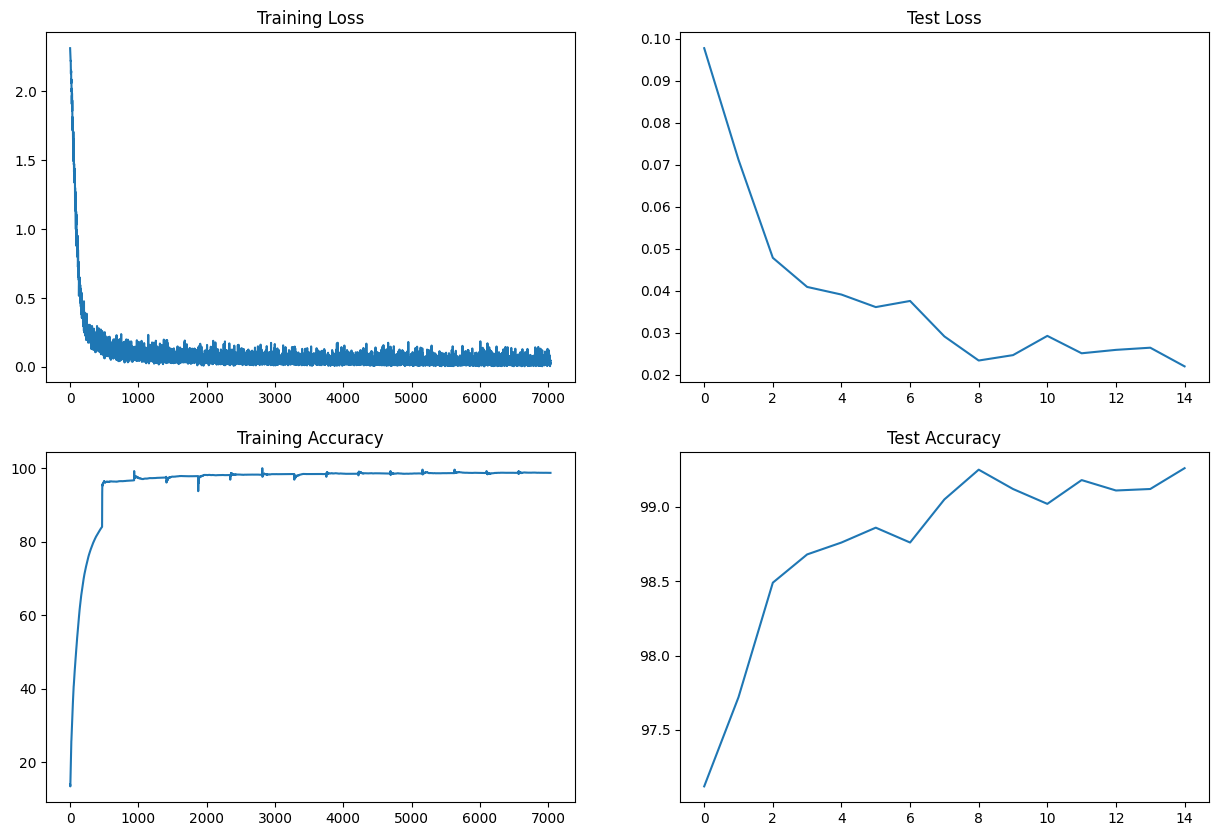

In [45]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")